In [1]:
import keras
import re
import numpy as np
import pandas as pd

import os
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
    
%matplotlib inline

Using TensorFlow backend.


In [2]:
DOMAIN = 'eclipse'
DIR = 'data/processed/{}'.format(DOMAIN)
DATASET = os.path.join('data/normalized/{}'.format(DOMAIN), '{}.csv'.format(DOMAIN))
DIR_PAIRS = 'data/normalized/{}'.format(DOMAIN)

In [3]:
df_train_pair = pd.read_csv(os.path.join(DIR_PAIRS, 'eclipse_pairs.csv'))
df = pd.read_csv(os.path.join(DIR_PAIRS, 'eclipse.csv'))

In [30]:
def create_bucket(data):
    print("Creating the buckets...")
    buckets = {}
    # Reading the buckets
    df_buckets = data[data['dup_id'] == '[]']
    loop = tqdm(total=df_buckets.shape[0])
    for row in df_buckets.iterrows():
        name = row[1]['bug_id']
        buckets[name] = set()
        buckets[name].add(name)
        loop.update(1)
    loop.close()
    # Fill the buckets
    df_duplicates = data[data['dup_id'] != '[]']
    loop = tqdm(total=df_duplicates.shape[0])
    for row_bug_id, row_dup_id in df_duplicates[['bug_id', 'dup_id']].values:
        bucket_name = int(row_dup_id)
        dup_id = row_bug_id
        while bucket_name not in buckets:
            query = df_duplicates[df_duplicates['bug_id'] == bucket_name]
            bucket_name = int(query['dup_id'])
        buckets[bucket_name].add(dup_id)
        loop.update(1)
    loop.close()
    return buckets

In [31]:
buckets = create_bucket(df)

Creating the buckets...


In [42]:
issues_by_buckets = {}
for bucket in tqdm(buckets):
    issues_by_buckets[bucket] = bucket
    for issue in np.array(buckets[bucket]).tolist():
        issues_by_buckets[issue] = bucket

In [35]:
buckets_at_least_2_dups = [bucket for bucket in buckets if len(buckets[bucket]) > 1]
buckets_alone = [bucket for bucket in buckets if len(buckets[bucket]) <= 1]

In [36]:
print("buckets_at_least_2_dups:", len(buckets_at_least_2_dups))
print("buckets_alone:", len(buckets_alone))

buckets_at_least_2_dups: 24413
buckets_alone: 297070


In [49]:
issues_by_buckets[214181], buckets[issues_by_buckets[214181]]

(214181, {214181})

#### Example 1

In [10]:
buckets[210304]

{214411, 216663, 216725, 218239}

In [11]:
df[df['bug_id'].isin([214411, 210304, 216725, 216725, 216663, 218239])]

,bug_id,bug_severity,bug_status,component,creation_ts,delta_ts,description,dup_id,priority,product,resolution,short_desc,version
194058,210304,normal,VERIFIED,IDE,2007-11-19 16:31:00 -0500,2008-02-07 16:11:08 -0500,+++ This bug was initially created as a clone ...,[],P3,Platform,FIXED,[Navigator] resourceFilters incorrectly read f...,3.3.1
197589,214411,normal,RESOLVED,IDE,2008-01-04 17:47:00 -0500,2009-10-01 09:36:04 -0400,I just started using Eclipse version 3.3.1.1 (...,210304,P3,Platform,DUPLICATE,ResourceNavigator filters appear to be totally...,3.3.1
199547,216663,normal,RESOLVED,IDE,2008-01-25 20:49:00 -0500,2009-10-01 09:36:04 -0400,Build ID: M20071023-1652\n\nSteps To Reproduce...,210304,P3,Platform,DUPLICATE,Navigator Filters dialog is empty,3.3.1
199591,216725,normal,RESOLVED,IDE,2008-01-28 04:06:00 -0500,2009-10-01 09:36:04 -0400,Build ID: M20071023-1652\n\nSteps To Reproduce...,210304,P3,Platform,DUPLICATE,resourceFilters extension point doesn't work,3.3.1
200918,218239,normal,RESOLVED,UI,2008-02-07 14:54:00 -0500,2008-02-07 16:11:08 -0500,Build ID: M20071023-1652\n\nSteps To Reproduce...,210304,P3,Platform,DUPLICATE,[Navigator View] Filters dialog is empty when...,3.3.1


#### Example 2

In [12]:
buckets[119056]

{119285, 119619, 119712, 119845, 120183}

In [13]:
df[df['bug_id'].isin(buckets[119056])]

,bug_id,bug_severity,bug_status,component,creation_ts,delta_ts,description,dup_id,priority,product,resolution,short_desc,version
112427,119285,normal,RESOLVED,Team,2005-12-05 13:38:00 -0500,2005-12-07 15:12:06 -0500,I20051130-1215\n*I have a java class in my wor...,119056,P3,Platform,DUPLICATE,Replace with uncommitted changes dialog shows ...,3.2
112736,119619,normal,RESOLVED,Team,2005-12-07 07:30:00 -0500,2005-12-09 09:07:33 -0500,I20051206\n\n1. Check out a Java project from ...,119056,P3,Platform,DUPLICATE,Replace with latest propose the same .java fil...,3.1
112812,119712,normal,RESOLVED,Team,2005-12-07 14:26:00 -0500,2005-12-07 15:12:06 -0500,Build: I-20051206 (and even the one from the w...,119285,P3,Platform,DUPLICATE,seeing double,3.1
112940,119845,normal,RESOLVED,Team,2005-12-08 07:01:00 -0500,2005-12-08 10:13:29 -0500,Take a project with some local changes you wan...,119056,P3,Platform,DUPLICATE,Replace with dialog shows projects multiple times,3.2
113262,120183,normal,RESOLVED,Team,2005-12-09 16:39:00 -0500,2005-12-09 16:52:38 -0500,See attached screenshot.\n\nThe dialog title i...,119056,P3,Platform,DUPLICATE,"Duplicate entries in ""Replace with uncommitted...",3.2


#### Example 3

In [14]:
buckets[288347]

{213528, 214971}

In [15]:
df[df['bug_id'].isin([214971, 288347, 213528])]

,bug_id,bug_severity,bug_status,component,creation_ts,delta_ts,description,dup_id,priority,product,resolution,short_desc,version
196813,213528,enhancement,RESOLVED,Jira,2007-12-19 15:58:00 -0500,2009-09-02 18:37:37 -0400,-- Created from Comment --\nURL: https://bugs....,288347,P2,Mylyn,DUPLICATE,only submit comment if none of the attributes ...,unspecified
198079,214971,normal,RESOLVED,Jira,2008-01-10 17:52:00 -0500,2009-09-17 19:45:23 -0400,Is unable to reassign a tasks through the acti...,288347,P3,Mylyn,DUPLICATE,unable to reassign tasks if no permissions to ...,2.2
259921,288347,enhancement,RESOLVED,Jira,2009-09-02 08:19:00 -0400,2009-09-24 05:37:43 -0400,User-Agent: Mozilla/5.0 (Macintosh; U; I...,[],P2,Mylyn,FIXED,only update comment or reassign if this is the...,3.2


### Ploting buckets after training

In [1]:
import re
import numpy as np
import pandas as pd

import os
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
import sys
from annoy import AnnoyIndex
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
    
%matplotlib inline

In [2]:
from methods.baseline import Baseline
from methods.experiments import Experiment
from methods.evaluation import Evaluation
from methods.retrieval import Retrieval

Using TensorFlow backend.


In [3]:
MAX_SEQUENCE_LENGTH_T = 100 # 100
MAX_SEQUENCE_LENGTH_D = 500 # 500
EMBEDDING_DIM = 300
MAX_NB_WORDS = 20000

In [4]:
# Domain to use
DOMAIN = 'netbeans'
METHOD = 'propose'
# Dataset paths
DIR = 'data/processed/{}'.format(DOMAIN)
DIR_PAIRS = 'data/normalized/{}'.format(DOMAIN)
DATASET = os.path.join('data/normalized/{}'.format(DOMAIN), '{}.csv'.format(DOMAIN))
# Glove embeddings
GLOVE_DIR='data/embed'
# Save model
SAVE_PATH = 'baseline_feature@number_of_epochs@epochs_64batch({})'.format(DOMAIN)
SAVE_PATH_FEATURE = 'baseline_feature_@number_of_epochs@epochs_64batch({})'.format(DOMAIN)

# Extract CORPUs
EXTRACT_CORPUS = False

In [5]:
baseline = Baseline(DIR, DATASET, MAX_SEQUENCE_LENGTH_T, MAX_SEQUENCE_LENGTH_D)
evaluation = Evaluation(verbose=0)
retrieval = Retrieval()
experiment = Experiment(baseline, evaluation)

In [6]:
experiment.set_retrieval(retrieval, baseline, DOMAIN)

Creating the buckets...


In [7]:
experiment.load_ids()
len(baseline.bug_ids)

Reading bug ids


216715

In [8]:
%%time

experiment.load_bugs()
len(baseline.sentence_dict)


CPU times: user 1min 25s, sys: 2.55 s, total: 1min 27s
Wall time: 1min 25s


In [9]:
issues_by_buckets = experiment.get_buckets_for_bugs()

In [10]:
%%time

experiment.prepare_dataset(issues_by_buckets, path_train='train_chronological', path_test='test_chronological')
# Read and create the test queries duplicates
retrieval.create_queries()

Reading train data
Reading bug ids
CPU times: user 2min 34s, sys: 21 ms, total: 2min 34s
Wall time: 2min 34s


In [11]:
bug_train_ids = experiment.get_train_ids(baseline.train_data)

In [12]:
from sklearn.manifold import TSNE
import random

def plot_2d(test_labels, tsne_features, categories):
    colors = [(random.uniform(0, 1), random.uniform(0, 1), random.uniform(0, 1)) for i in enumerate(test_labels)]
    plt.figure(figsize=(10, 10))

    for c_color, c_label in zip(colors, categories):
        plt.scatter(tsne_features[np.where(test_labels == c_label), 0],
                    tsne_features[np.where(test_labels == c_label), 1],
                    marker='o',
                    color=c_color,
                    linewidth='1',
                    alpha=0.8,
                    label=c_label)
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.title('t-SNE on Buckets')
    plt.legend(loc='best')
    #plt.savefig('clothes-dist.png')
    plt.show(block=False)

def create_features(x_test_features):
    tsne_obj = TSNE(n_components=2,
                            init='pca',
                            random_state=101,
                            method='barnes_hut',
                            n_iter=500,
                            verbose=0)
    tsne_features = tsne_obj.fit_transform(x_test_features)
    return tsne_features

In [13]:
model = experiment.get_model_vectorizer(path=SAVE_PATH_FEATURE.replace('@number_of_epochs@', '100'))

/usr/local/lib/python3.5/dist-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [14]:
buckets_2_dups = [bucket for bucket in retrieval.buckets if len(retrieval.buckets[bucket]) == 2]
buckets_biggest_2_dups = [bucket for bucket in retrieval.buckets if len(retrieval.buckets[bucket]) > 2]
buckets_3_dups = [bucket for bucket in retrieval.buckets if len(retrieval.buckets[bucket]) == 3]
buckets_5_dups = [bucket for bucket in retrieval.buckets if len(retrieval.buckets[bucket]) == 5]
buckets_between_5_and_10_dups = [bucket for bucket in retrieval.buckets if len(retrieval.buckets[bucket]) > 5 and len(retrieval.buckets[bucket]) <= 10]
buckets_biggest_10_dups = [bucket for bucket in retrieval.buckets if len(retrieval.buckets[bucket]) > 10]

In [15]:
len(buckets_2_dups), len(buckets_3_dups), len(buckets_5_dups), len(buckets_between_5_and_10_dups), len(buckets_biggest_10_dups)

(13589, 3411, 628, 897, 228)

In [16]:
import numpy as np

test_features = []
#bucket_labels = ['2 duplicados', '3 duplicados', '5 duplicados', 'Entre 5 e 10 duplicados', 'Acima de 10 duplicados']
bucket_labels = ['2 duplicados', 'Acima de 2 duplicados']

number_of_instances = 50

buckets_selected = np.concatenate([ 
                                buckets_2_dups,
                                buckets_biggest_2_dups,
#                                 np.random.choice(buckets_3_dups, number_of_instances),
#                                 np.random.choice(buckets_5_dups, number_of_instances),
#                                 np.random.choice(buckets_between_5_and_10_dups, number_of_instances),
#                                 np.random.choice(buckets_biggest_10_dups, number_of_instances)
                              ], 0)

label_buckets_2_dups = np.full((1, number_of_instances), bucket_labels[0])
label_buckets_biggest_2_dups = np.full((1, number_of_instances), bucket_labels[1])
# label_buckets_3_dups = np.full((1, number_of_instances), bucket_labels[1])
# label_buckets_5_dups = np.full((1, number_of_instances), bucket_labels[2])
# label_buckets_between_5_and_10_dups = np.full((1, number_of_instances), bucket_labels[3])
# label_buckets_biggest_10_dups = np.full((1, number_of_instances), bucket_labels[4])

# categories = np.concatenate([label_buckets_2_dups, label_buckets_3_dups, 
#                              label_buckets_5_dups, label_buckets_between_5_and_10_dups, label_buckets_biggest_10_dups], -1)[0]

categories = np.concatenate([label_buckets_2_dups, label_buckets_biggest_2_dups], -1)[0]

title_data, desc_data, info_data = [], [], []

for bucket in buckets_selected:
    # bucket and dups
    dups = list(retrieval.buckets[bucket])
    for dup in dups:
        if dup not in baseline.bug_set: continue
        bug = baseline.bug_set[dup]
        title_data.append(bug['title_word'])
        desc_data.append(bug['description_word'])
        info_data.append(experiment.retrieval.get_info(bug))
    
test_features = model.predict([ np.array(title_data), np.array(desc_data), np.array(info_data) ])

### Visualizing bucket space

Plota um conjunto de duplicados pintando o mestre de uma cor e os seus duplicados de outra

In [17]:
test_features.shape, len(categories), len(bucket_labels)

((336, 900), 100, 2)

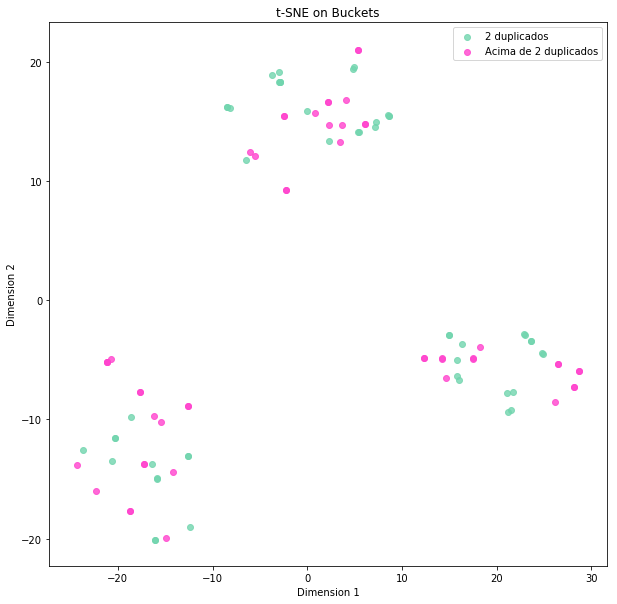

In [18]:
tsne_features = create_features(test_features)

plot_2d(categories, tsne_features, bucket_labels)